## **Assignment 1 - Bandit Problems**

Assume there are N lottery ball machines, in which there are 2 kinds of ball, red ball and white ball. If the machine throw up a red ball, you will get a bonus, but if it's a white ball, you will get nothing.

To maximum the bonus, we use the following code to model this problem.

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret


In [125]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward
  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

In [77]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [78]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [79]:
# random sampling class
class RandomSampling():
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count

    @staticmethod
    def name():
        return 'random'

    def get_action(self):
        # choose a random mechine
        action = np.random.randint(0, self.arm_count)
        return action

    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        return reward, regret

In [80]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

### **Questions**

1. **Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling? Show that they are important (15 Points)** 

    * **Thompson Sampling**:     
        No hyperparameter.


    * **E-greedy**:     
        Epsilon. It decides the ratio that balances exploration and exploitation. If the generated random number is less than epsilon, this round the agent will try a random mechine. If the generated random number is larger, this round the agent will choose the mechine that has best Q-value in the past rounds. According to the experiments, too small epsilon will decrease the speed of convergency, while too large epsilon will make training converge to worse level.


    * **UCB**:     
        Constant c. According to the formula, it will decide how often the exploitation process is. C is larger, Q-value is less important in the choosing, which means that the agent will be more likely to choose a mechine to explore rather than to choose a known best mechine to exploit. According to the experiments, less c value makes UCB converge faster. But after a while the training will hardly improve. If c value is too large, the training will be too slow.


    * **Random Sampling**:     
        No hyperparameter.



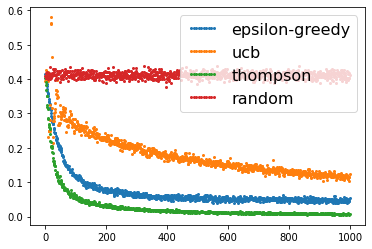

In [81]:
# Control group
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary= True
experiment(arm_count)

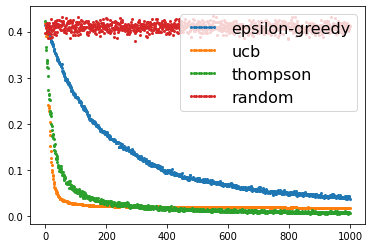

In [129]:
# Experiment group 1 (smaller epsilon and c value)
arm_count = 10 # number of arms in bandit
epsilon = 0.02
ucb_c = 0.1
stationary= True
experiment(arm_count)

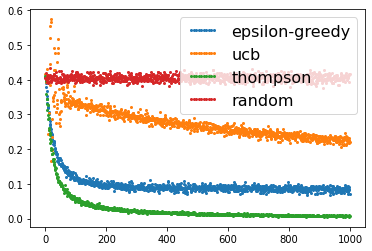

In [88]:
# Experiment group 2 (bigger epsilon and c value)
arm_count = 10 # number of arms in bandit
epsilon = 0.2
ucb_c = 4
stationary= True
experiment(arm_count)

2. **How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points)** 

    With the action space growing, all of the algorithms have been affected negatively.

    Thompson will optimize more slowly, but still can converge to a low regret level.

    E-greedy has still the quick convergence, but with increasing the time steps, its performanse is worse than Thompson.
    
    UCB has been significantly affected, the result is unstable and hardly convergent. 

    Random sampling keeps no-optimization shape, but the regret increasing from 0.4 to 0.5.

    The reason why Thompson and UCB are affected a lot is that, these two ways need to make the beta distributions or bounds exact through training. The more action space, the harder they make each mechine be trained enough. Hence they cannot decide exact and right. *"The greedy algorithm need only sample a few values and has a high probability of its most favourable action's estimated reward probability being close to the true optimal reward probability, ensuring it a low regret, even if it never chooses the optimal action."*\*

    \* *from https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb*

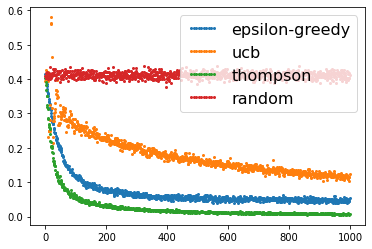

In [ ]:
# Control group
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary= True
experiment(arm_count)

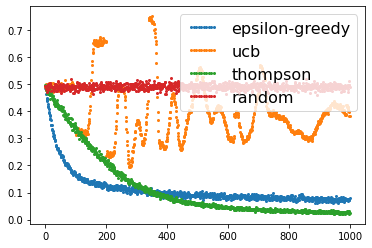

In [82]:
# Experiment 1
arm_count = 100 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary= True
experiment(arm_count)

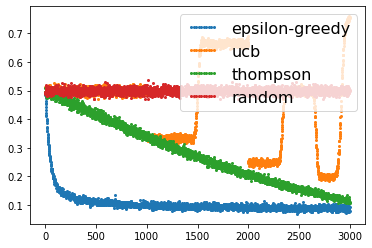

In [84]:
# Experiment 2
arm_count = 1000 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary= True
experiment(arm_count,timesteps=3000)

3. **How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling? Show why. (15 Points)**

    *"This places special emphasis on exploration. An algorithm that converges to an action and does not emphasize exploration will perform quite poorly as the true reward distribution changes over time. Below we see a clear jump in regret every time the true bandit parameters are resampled (every 100 steps). While the $\epsilon$-greedy and Thompson's regret quickly decrease, on average they increase over time. On the other hand, UCB reacts much more quickly to the bandit non-stationarity, and actually continues to improve in regret over time, no doubt due to its higher emphasis on exploration. We confirm this in the next experiment."*\*
    
    \* *from https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb*

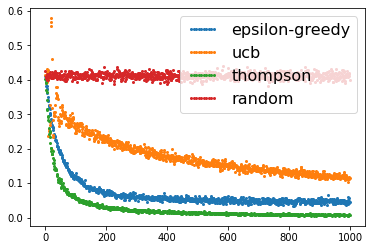

In [130]:
# Control group
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

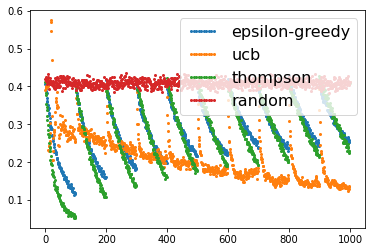

In [131]:
# Experiment group
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

4. **When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring? Explain why. Explain the exploration-exploitation tradeoff (15 Points)**

    * Thompson sampling will stop exploration, when there is no overlap part between the beta distribution of the best mechine with the others, which means that there is no possibility that the beta value generated by the other mechines is larger than the best mechines. Because that is the EE(exploration-exploitation) tradeoff mechanism of Thompson sampling. It will sample beta values each round. If there is a overlap, there is possible that the worse mechine generate a larger beta value. So that the agent will choose the worse mechine this round as the exploration.
    
    * E-greedy will stop exploration when the epsilon value becomes 0 (normally there is a decline ratio as the htperparameter).Because it simply divide exploration and exploitation. When the random number is less than epsilon, the agent will choose a new mechine to explore. When the random number is larger than epsilon, the agent will choose the best mechine to exploit it. 

    * UBC will stop exploration when the lower confidence bound of the best mechine is beyond the upper confidence bounds of the other mechines. Because UCB balance EE tradeoff by confidence bound. The length of confidence bound of the best mechine will decrease with more and more training, until there is possible that a worse machine can have the higher upper confidence bound because it is chosen less and its bound is longer. When even the lower confidence bound of the best mechine is higher than others, the exploration will stop.

    * Random Sampling will not stop exploration.


5. **How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions? Explain your answer. (10 Points)**

    * Thompson sampling will wlways remember the past actions to calculate the alphas (the number of winning) and betas (the number of losing).

    * E-greedy and UBC will not remember the actual action, but they remember the total number of playing and use the action to calculate the responding Q value.

    * Random sampling will not care about the past actions. It does not remember or use them.



6. **Thompson Sampling with non-Beta distribution (5 Points) Modify the Thompson Sampling to run with a different distribution (e.g. Parteo, Normal, etc)**



In [134]:
# Use normal distribution instead of beta distribution
class BernThompsonNormal():

  # initialize
  def __init__(self, bandit):
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.record = [] # N*M ndarray, to record the each round result for each mechine
    self.mean = np.ones(self.arm_count) # assume each mechine wins once
    self.var = np.zeros(self.arm_count) # the variance is 0
    for i in range(0,self.arm_count):
      self.record.append([1]) # initialize records

  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.record[arm] = np.append(self.record[arm],reward) # update records
    self.mean[arm] = self.record[arm].mean() # calculate the new mean
    self.var[arm] = self.record[arm].var() # calculate the new variance

  @staticmethod
  def name():
    return 'thompson normal'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the normal distribution"""
    theta = np.random.normal(self.mean, self.var) # normal distribution
    return theta.argmax()

# new experiment function
def experiment2(arm_count, timesteps=1000, simulations=1000):
    algos = [EpsilonGreedy, UCB, BernThompsonNormal, RandomSampling]
    regrets = []
    names = []
    for algo in algos:
      regrets.append(simulate(simulations, timesteps, arm_count, algo))
      names.append(algo.name())
    multi_plot_data(regrets, names)

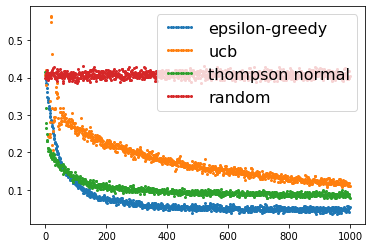

In [135]:
# Experiment 1
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary= True
experiment2(arm_count)

7. **What code is yours and what have you adapted? (10 Points)**

    I write a new random sampling class, a new thompson sampling class with normal distribution and a new experiment function.

    Besides, I adjust the experiments to make it based on the questions and have the corresponding control group and experiment group(s) so that the conclusion can be clear.

    The codes and commits are above, in the corresponding question parts.

MIT License

Copyright (c) 2021 Tianhui Zhang

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.